In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
b = 1; v = 0.25; λ = 0.25

In [3]:
N = 400; #16
Nq = N; #128
om = 0.3;
k_spacex, k_spacey = np.mgrid[-1.5:1.5:N*1j,-1.5:1.5:N*1j]
#k_spacex1, k_spacey1 = np.ogrid[-1.5:1.5:500j,-1.5:1.5:500j]
test = [k_spacex, k_spacey]
var = np.zeros([len(k_spacex),len(k_spacex)])



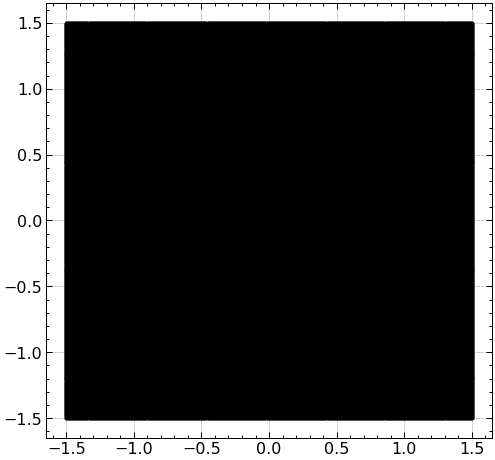

In [4]:
plt.figure(figsize=(8,8))
plt.plot(k_spacex, k_spacey, marker='.', color='k', linestyle='none')

plt.show()

![](ham.PNG)

![](k.PNG)

Note: $m\rightarrow \inf$


![](dispersion.PNG)

In [5]:
σx = np.array([[0, 1],[1, 0]]); σy = np.array([[0, -1j],[1j, 0]]); σz = np.array([[1, 0],[0, -1]])
def ϵplus(k):
    k_x, k_y = k
    return np.sqrt(v**2*(k_x**2+k_y**2)+λ**2/4*((k_y+1j*k_x)**3+(k_y-1j*k_x)**3)**2)

def H(k, p = np.array([1, 0.25, 0.25])):
    k_x, k_y = k
    b, v, λ = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x
    return v*(k_x*σy-k_y*σx)+λ/2*(kp**3+km**3)*σz

def H0(k, p = np.array([1, 0.25, 0.25])):
    k_x, k_y = k
    b, v, λ = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x
    return v*(k_x*σy-k_y*σx)

print(ϵplus([0.2,1.1]))
print(H([0.2,1.1]))

(0.40984760887432303+0j)
[[ 0.29975+0.j   -0.275  -0.05j]
 [-0.275  +0.05j -0.29975+0.j  ]]


In [6]:
from numpy import linalg as LA
def G0(k, ω):
    kx, ky = k
    Ham = H(k); 
    λ, v = LA.eig(Ham)
    summ = np.zeros([2,2])
    for n in range(len(λ)):
        g = (ω+1j*0.01-λ[n])**(-1)
        ψ = v[n]
        summ = summ+g*np.matmul(np.transpose(ψ), np.conj(ψ))
    return summ
print(G0([0.2,1.1], 0.2))       

[[-3.11525273-0.25345302j -3.11525273-0.25345302j]
 [-3.11525273-0.25345302j -3.11525273-0.25345302j]]


In [7]:
k_spacex1, k_spacey1 = np.mgrid[-0.5*np.pi:0.5*np.pi:N*1j,-0.5*np.pi:0.5*np.pi:N*1j]

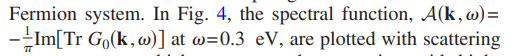

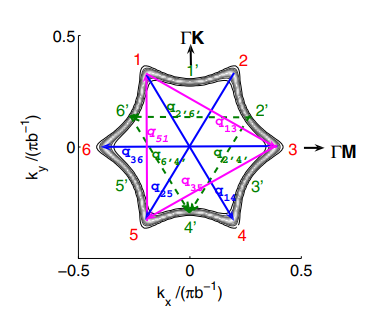

In [8]:
def A(k, ω):
    return -1/np.pi*np.imag(np.trace(G0(k, ω)))

for i in tqdm(range(N), desc="Spectral Function Iterations"):
    for j in range(N):
        var[i, j] = A([k_spacex1[i, j], k_spacey1[i, j]], om)/np.pi
    
        

Spectral Function Iterations: 100%|██████████| 400/400 [00:12<00:00, 31.79it/s]


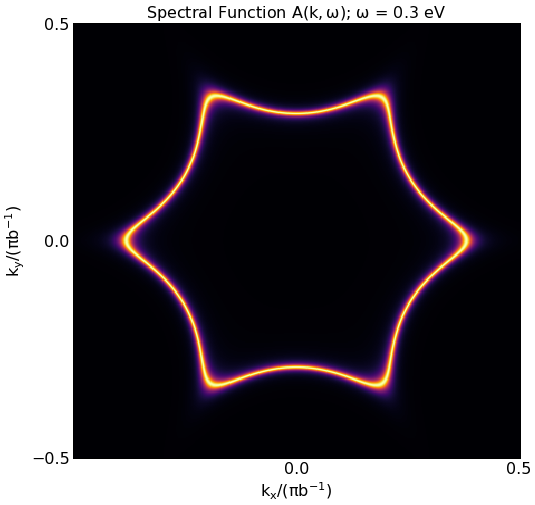

In [9]:
plt.figure(figsize=(8,8))
plt.pcolormesh(k_spacex1/np.pi,k_spacey1/np.pi, var, shading = 'auto', cmap = 'inferno')
plt.title("Spectral Function $A(k, ω)$; ω = 0.3 eV")
plt.xlabel('$k_x/(πb^{-1})$')
plt.ylabel('$k_y/(πb^{-1})$')
plt.yticks([-0.5, 0, 0.5])
plt.xticks([0, 0.5])

plt.show()

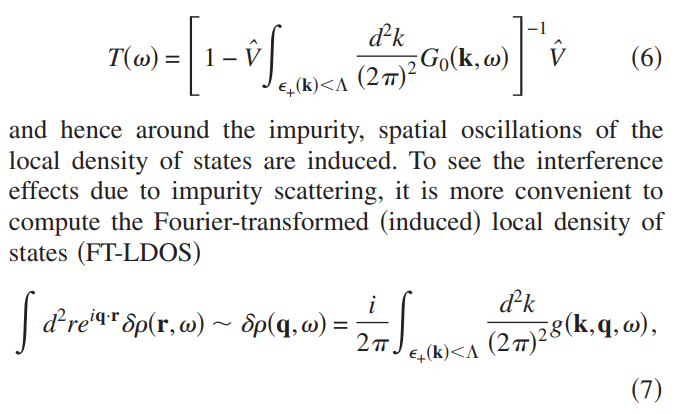

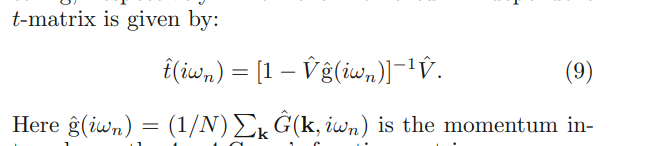



In [10]:
k_spacex3, k_spacey3 = np.mgrid[-np.pi:np.pi:N*1j,-np.pi:np.pi:N*1j]

In [11]:
V = 0.05/len(k_spacex)*np.eye(2)

In [12]:
from numpy.linalg import inv
def T(ω):
    summm = np.zeros([2,2])
    for i in tqdm(range(N), desc="T-Matrix"):
        for j in range(N):
            summm = summm + G0([k_spacex3[i, j], k_spacey3[i, j]], ω)/N
    return np.matmul(inv(np.eye(2)-np.matmul(V, summm)), V)

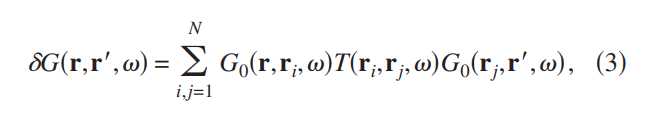
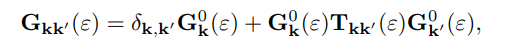

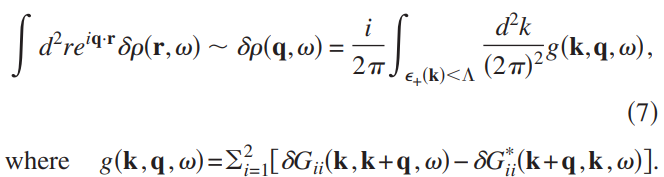

In [13]:

T1 = T(om) #outside of function speeds up

T-Matrix: 100%|██████████| 400/400 [00:11<00:00, 33.99it/s]


In [14]:
q_spacex3, q_spacey3 = np.mgrid[-np.pi:np.pi:Nq*1j,-np.pi:np.pi:Nq*1j]

In [15]:
# def DOS(q, ω = om):
#     #G1 = G(k, k+q)
#     #G2 = (-1*G(k+q, k)).getH()
#     summ = 0+0*1j
#     for i in range(N):
#         for j in range(N):
#             k = np.array([k_spacex3[i,j], k_spacey3[i,j]])
#             G0k = G0M[i,j]
#             G0kq = np.roll(G0M, 
#             G0kq1 = G0kq[i,j]
#             G1 = np.trace(G(G0k, G0(k+q, om)))
#             G2 = -1*np.trace(G(G0(k+q, om), G0k).conj().T)
#             summ = summ+G1+G2
#     return np.real(1j*summ/(2*np.pi)**3)
# #go = DOS(np.array([0,1]))
# print(DOS(np.array([0,1])))

In [16]:
sol = np.zeros((Nq,Nq))
qf = np.array([q_spacex3, q_spacey3])

In [17]:
G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mp[i,j] = G0([k_spacex3[i, j], k_spacey3[i, j] ], om)

G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mm[i,j] = G0([-1*k_spacex3[i, j], -1*k_spacey3[i, j] ], om)
            

G0-Matrix: 100%|██████████| 400/400 [00:13<00:00, 30.51it/s]


In [18]:
G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')

for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mpconj[i,j] = G0Mp[i,j].conj()
            
for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mmconj[i,j] = G0Mp[i,j].conj()

print()

G0-Matrix HT: 100%|██████████| 400/400 [00:00<00:00, 1480.29it/s]

In [19]:
#print(G0M[:,:,0,0])
def DOS(w = om):
    fact = 1j/(2*np.pi)/N
    res = np.zeros([N,N], dtype = 'complex')
    T2 = T1.conj()
    
    for m in range(2):
        for n in range(2):
            for j in tqdm(range(2), desc="G0-Matrix"):
        #                 Gp1 = np.fft.fft(G0Mp[:,:,n,j])
        #                 Gm1 = np.fft.fft(G0Mm[:,:,j,m])
        #                 G1 = np.fft.ifft(np.multiply(Gp1,Gm1))
        #                 Gp2 = np.fft.fft(G0Mpconj[:,:,j,m])
        #                 Gm2 = np.fft.fft(G0Mmconj[:,:,n,j])
        #                 G2 = np.fft.ifft(np.multiply(Gp2,Gm2))
                Gp1 = (np.fft.fft2(fftshift(G0Mp[:,:,n,j])))
                Gm1 = (np.fft.fft2(fftshift(G0Mm[:,:,j,m])))
                G1 = np.fft.ifft2((np.multiply((Gp1),(Gm1))))
                Gp2 = (np.fft.fft2(fftshift(G0Mpconj[:,:,j,m])))
                Gm2 = (np.fft.fft2(fftshift(G0Mmconj[:,:,n,j])))
                G2 = np.fft.ifft2((np.multiply(Gp2,Gm2)))



            res = res+T1[m,n]*(G1)-T2[m,n]*(G2)
    
    sol = (np.real(ifftshift(fact*res)))
    return sol

In [20]:
sol = DOS()
print(sol)

G0-Matrix: 100%|██████████| 2/2 [00:00<00:00, 26.50it/s]

[[-0.00255888 -0.00254019 -0.00251021 ... -0.00254019 -0.00255888
  -0.00256523]
 [-0.00260851 -0.00258965 -0.00255929 ... -0.00258965 -0.00260851
  -0.0026149 ]
 [-0.00269049 -0.0026715  -0.00264072 ... -0.0026715  -0.00269049
  -0.00269691]
 ...
 [-0.00260851 -0.00258965 -0.00255929 ... -0.00258965 -0.00260851
  -0.0026149 ]
 [-0.00255888 -0.00254019 -0.00251021 ... -0.00254019 -0.00255888
  -0.00256523]
 [-0.00254228 -0.00252366 -0.00249382 ... -0.00252366 -0.00254228
  -0.00254861]]


In [21]:
# for i in tqdm(range(Nq), desc="DOS"):
#         for j in range(Nq):
#             #var[i, j] = A([k_spacex1[i, j], k_spacey1[i, j]], 0.3)/np.pi
#             sol[i, j] = DOS(qf[:,i, j])
q_spacex4, q_spacey4 = (np.mgrid[-np.pi:np.pi:N*1j,-np.pi:np.pi:N*1j])

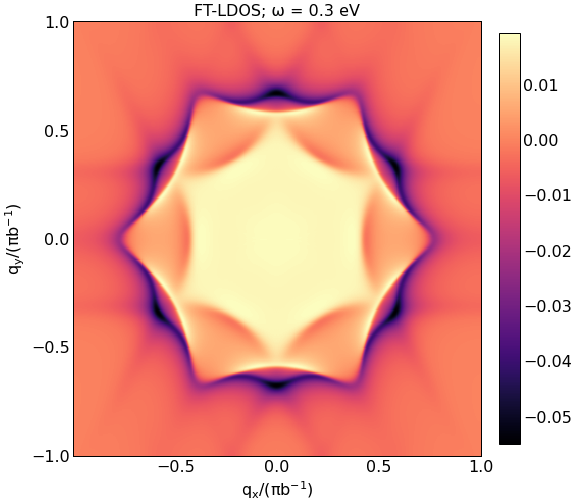

In [22]:
plt.figure(figsize=(8,8))
plt.pcolormesh(q_spacex4/np.pi,q_spacey4/np.pi, sol/(2*np.pi), cmap = "magma", shading = 'auto')
plt.title("FT-LDOS; ω = 0.3 eV")
plt.xlabel('$q_x/(πb^{-1})$')
plt.ylabel('$q_y/(πb^{-1})$')
plt.yticks([-1, -0.5 ,0, 0.5, 1])
plt.xticks([ -0.5 ,0, 0.5, 1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('QPI 03 eV 400', bbox_inches='tight')
plt.show()

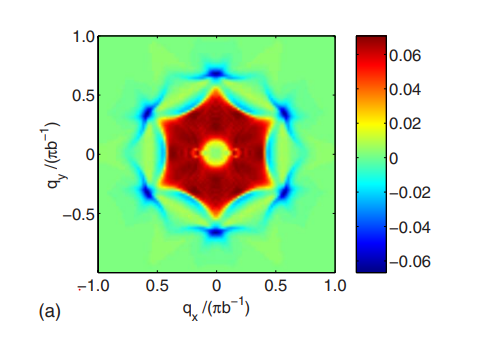

C:\Users\Nunocastanheira\anaconda3\lib\site-packages\numpy\ma\core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


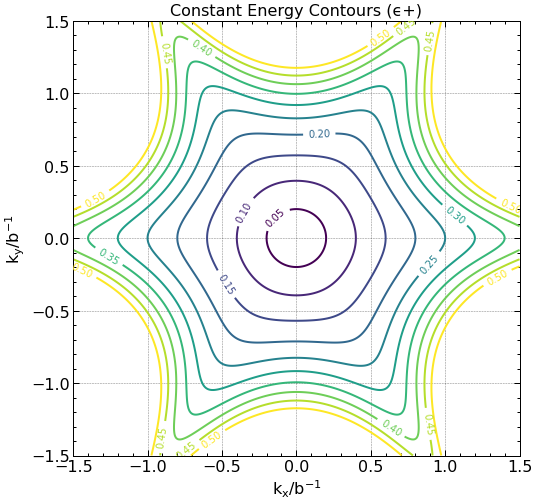

In [23]:
plt.figure(figsize=(8,8))
CS = plt.contour(k_spacex,k_spacey, ϵplus([k_spacex, k_spacey]), levels = [0.05, 0.05*2, 0.05*3, 0.05*4, 0.05*5, 0.3, 0.35, 0.4, 0.45, 0.5] )
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Constant Energy Contours (ϵ+)')
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
#labels = ['ω = 0.05','ω =0.3']
# for i in range(len(labels)):
#     CS.collections[i].set_label(labels[i])
plt.xlabel('$k_x/b^{-1}$')
plt.ylabel('$k_y/b^{-1}$')

plt.show()

In [24]:
plt.figure(figsize=(8,8))
plt.pcolormesh(k_spacex,k_spacey, ϵplus([k_spacex, k_spacey]), shading = 'auto', cmap = 'inferno')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

C:\Users\Nunocastanheira\anaconda3\lib\site-packages\matplotlib\transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


TypeError: Cannot cast array data from dtype('complex128') to dtype('int64') according to the rule 'safe'

<Figure size 576x576 with 2 Axes>